### The QLBS Model

이제 Markov Dicision Process의 framework를 사용해 3절에서 제시한 이산 시간 BSM을 재구성하고 일반화한다. 핵심 아이디어는 이산 시간에서의 위험 기간 가격 결정과 헤징을 가치함수를 가진 MDP문제로 이해할 수 있다는 것이다. 이 가치 함수를 옵션 매도자에 대한 음의 위험 조정 옵션 가격으로 정의했다는 점을 상기하자.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. State Variables

주가 동학은 일반적으로 결정적 추세 항을 포함하므로 새로운 시간 변환 변수가 정상성을 갖게, 즉 비추세적이 되도록 상태 변수의 변경을 고려할 수 있다. 주어진 주가 프로세스 $S_t$에 대해 다음 관계에 의해서 새로운 변수 $X_t$를 정의함으로써 이를 달성할 수 있다.

$$X_t = -\left( \mu - \frac{\sigma^2}{2}\right)t + \log S_t$$

이 표현의 장점은 $S_t$가 Geometric Brownian Motion인 특수한 경우에서 분명히 볼 수 있다. 이 경우 다음을 얻는다.

$$dX_t = - \left( \mu - \frac{\sigma^2}{2}\right)dt + d\log S_t = \sigma d W_t$$

따라서 $S_t$의 실제 동학이 로그 정규분포일 때 $X_t$는 변동성 $\sigma$에 의해 크기 조정된 표준 브라운 운동이다. 주어진 MC 시나리오에서 $X_t$를 안다면 $S_t$의 상응하는 값은 다음 공식에 의해 주어진다.

$$S_t = e^{X_t + \left( \mu - \frac{\sigma^2}{2}\right)t}$$

$\{X_t\}_{t=0}^T$이 martingale, 즉 $\mathbb{E}[dX_t] = 0, \forall t$인 한 평균적으로 옵션의 생애 동안 포기값 $X_0$으로부터 너무 떨어지지 않을 것이다. 상태 변수 $X_t$는 추세 항을 갖는 주가 $S_t$와 달리 time-uniform이다. 그러나 관계식 $S_t = e^{X_t + \left( \mu - \frac{\sigma^2}{2}\right)t}$는 $S_t$의 비정상성 동학을 $X_t$의 정상성 동학에 매핑하고자 항상 사용될 수 있다. $X_t$의 martingale 속성은 주가의 가능한 미래 변동을 포착하고자 그리드가 너무 커서는 안 된다는 것을 의미하기 때문에 수치 그리드 근사에도 도움이 된다.

식 $X_t = -\left( \mu - \frac{\sigma^2}{2}\right)t + \log S_t$의 변수 변화와 그 역도 주가 동학이 GBM이 아닐 때 적용할 수 있다. 물론 이 경우 새로운 상태 변수 $X_t$기 일반적으로 Martingale이 되지는 않겠지만 최적화 작업의 비정상성과 상태 변수의 비정상성을 분리하는 데 본질적으로 유용하다.

In [2]:
# Parameters
mu = 0.05  # Drift term
sigma = 0.2  # Volatility
T = 1.0  # Time horizon (in years)
dt = 0.01  # Time step
n_steps = int(T / dt)
n_simulations = 1000  # Number of Monte Carlo paths

In [3]:
# Initial stock price
S0 = 100
X0 = np.log(S0)

# Time grid
t = np.linspace(0, T, n_steps)

In [4]:
# Generate Brownian motion paths
dW = np.random.normal(0, np.sqrt(dt), (n_simulations, n_steps - 1))
W = np.cumsum(dW, axis=1)

In [5]:
# Calculate X_t and S_t
X_t = X0 + (- (mu - (sigma**2) / 2) * t[1:]) + sigma * W
X_t = np.insert(X_t, 0, X0, axis=1)  # Insert initial state

S_t = np.exp(X_t + (mu - (sigma**2) / 2) * t)

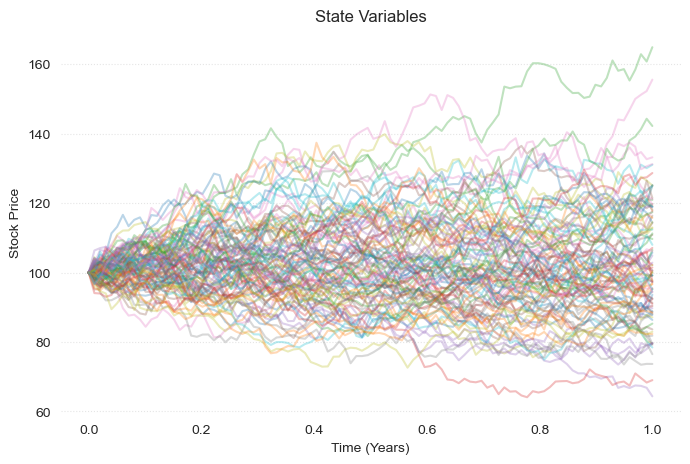

In [12]:
fig, ax = plt.subplots(figsize = (8, 5))
for i in range(100):
    ax.plot(t, S_t[i], alpha = 0.3)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('State Variables')
plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.show()

### 2. Bellman Equations

3.2절에서 설정한 위험 최소화 절차를 MDP 문제의 언어로 다시 설명하는 것으로 시작한다. 특히 time dependent state variable인 $S_t$는 식 $S_t = e^{X_t + \left( \mu - \frac{\sigma^2}{2}\right)t}$을 사용해 time-homogeneous variable $X_t$로 표현횐다. 또한 $a_t = a_t(X_t)$의 표기법을 사용해 시간 동질 변수 $X_t$의 함수로 표현되는 행동을 나타낼 것이다. 주가로 표현한 행동 $ut = u_t(S_t)$는 다음의 대입을 통해 구한다. 

$$u_t (S_t) = a_t(X_t(S_t)) = a_t \left(\log S_t - \left( \mu - \frac{\sigma^2}{2}\right)t\right)$$

여기서 식 $X_t = -\left( \mu - \frac{\sigma^2}{2}\right)t + \log S_t$을 사용하였다. $x_t$가 시점 $t$의 랜덤 상태 $X_t$의 특정 실현인 실제 헤징 결정 $a_t(x_t)$와 임의의 상태 $X_t$에 적용되는 헤징 전략을 구별하고자 시간 의존적 정책 $\pi(t, X_t)$의 개념을 도입한다. 다음 형태의 결정적 정책을 고려한다.

$$\pi : \left\{ 0, \dots, T-1\right\} \times \mathcal{X} \rightarrow \mathcal{A}$$

이는 시점 $t$와 현재 상태 $X_t = x_t$를 행동 $a_t \in \mathcal{A}$에 매핑하는 결정적 정책이다.

$$a_t = \pi(t, x_t)$$

여기서 새로운 상태 변수 $X_t$와 이의 정책 $\pi$에 대한 의존성을 표기한 위첨자 인덱스로 다시 표현한 식의 최대화 문제로 시작한다.

$$
\begin{align}
V_t^{\pi}(X_t) = & \mathbb{E} \left[ -\Pi_t(X_t) - \lambda \sum_{t^\prime = t}^T e^{-r(t^\prime - t)} \text{Var}\left[\Pi_{t^\prime} (X_{t^\prime}) | \mathcal{F}_{t^\prime} \right] \vert \mathcal{F}_t\right] \\ 
= & \mathbb{E} \left[  -\Pi_t(X_t)  - \lambda \text{Var}[\Pi_t] -  \lambda \sum_{t^\prime = t}^T e^{-r(t^\prime - t)} \text{Var}\left[\Pi_{t^\prime} (X_{t^\prime}) | \mathcal{F}_{t^\prime} \right] \vert \mathcal{F}_t \right]
\end{align}
$$

$t = t+1$에서 $t=T$까지의 합과 관련된 이 식의 마지막 항은 이동된 시간 인수를 가진 가치 함수의 정의를 사용해 다음과 같이 $V_{t+1}$의 항으로 표현할 수 있다.

$$-\lambda \mathbb{E}_{t+1} \left[ \sum_{t^\prime = t+1}^T e^{-r(t^\prime - t)} \text{Var}[\Pi_{t^\prime} \vert \mathcal{F}_{t^\prime}]\right] = 
\gamma \left( V_{t+1} + \mathbb{E}_{t+1}[\Pi_{t+1}]\right), \qquad \gamma := e^{-r \Delta t}$$

마지막 관계식에서 도입된 parameter $\gamma$는 원래의 BSM 모델의 연속 시간 무위험 이자율 $r$의 항으로, 우리의 framework에서 고정된 이산 시간 할인 계수이다. 이를 정리하고 포트폴리오 프로세스 식을 사용하면 QLBS 모델에 대한 벨만 방정식을 얻는다.

$$V_t^{\pi}(X_t) = \mathbb{E}_t^{\pi} \left[ R(X_t, a_t, X_{t+1} + \gamma V_{t+1}^{\pi} (X_{t+1})\right]$$

여기서 1-step time dependent 랜덤 보상은 다음과 같이 정의된다.

$$
\begin{align}
R_t(X_t, a_t, X_{t+1}) = & \gamma a_t \Delta S_t (X_t, X_{t+1}) - \lambda \text{Var} \left[ \Pi_t \vert \mathcal{F}_t \right], \qquad t = 0, \dots, T-1 \\ 
=& \gamma a_t \Delta S_t(X_t, X_{t+1}) - \lambda \gamma^2 \mathbb{E}_t \left[ \hat{\Pi}_{t+1}^2 - 2a_t \Delta \hat{S}_{t} \hat{\Pi}_{t+1} + a_t^2 \left( \Delta \hat{S}_t\right)^2\right]
\end{align}
$$

이러한 기대 보상은 현금과 단일 주식으로 구성된 포트폴리오의 특별한 경우에 대한 단일기간 Markowitz Portfolio 모델의 위험 조정 수익률과 동일한 수학적 구조를 갖는다. 첫 번째 항은 그러한 포트폴리오에서 예상되는 수익률을 제공하는 반면, 두 번째 항은 포트폴리오의 2차 함수 위험에 대해 패널티를 부여한다. $\lambda \rightarrow 0$일 때 예상되는 보상은 $a_t$에 선형이므로 최대값이 없다.

In [22]:
# Parameter for risk-free rate and time step
r = 0.05  # Risk-free interest rate

# Calculate gamma
gamma = np.exp(-r * dt)

In [23]:
gamma

0.9995001249791693

In [34]:
# Portfolio value and risk penalty parameter
Pi_t = 10
lambda_ = 0.5

# Generate random variance for future values
var_Pi_future = np.random.rand(n_simulations, len(t))

In [38]:
# Calculate the discount factors for each time step
discount_factors = np.exp(-r * (t - t[0]))  # Shape (n_steps,)

# Ensure discount_factors is broadcastable with var_Pi_future
discount_factors = discount_factors[np.newaxis, :]  # Shape (1, n_steps)

In [39]:
# Calculate discounted variance sum
V_t_pi_paths = -Pi_t - lambda_ * np.sum(discount_factors * var_Pi_future, axis=1)

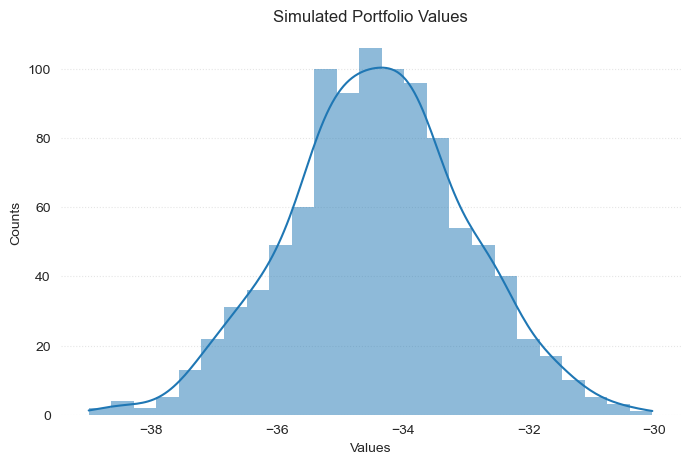

In [48]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (8, 5))
sns.histplot(V_t_pi_paths, ax = ax, edgecolor = 'None', kde = True)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Simulated Portfolio Values')
plt.xlabel('Values')
plt.ylabel('Counts')
plt.show()

In [49]:
# Generate stock price changes for 1-step reward calculation
a_t = 0.5  # Example action
delta_S_t = np.random.randn(n_simulations, len(t)) * sigma * np.sqrt(dt)

In [50]:
# Calculate 1-step reward R_t
R_t_paths = gamma * a_t * delta_S_t - lambda_ * gamma**2 * (Pi_t**2 - 2 * a_t * delta_S_t * Pi_t + a_t**2 * delta_S_t**2)

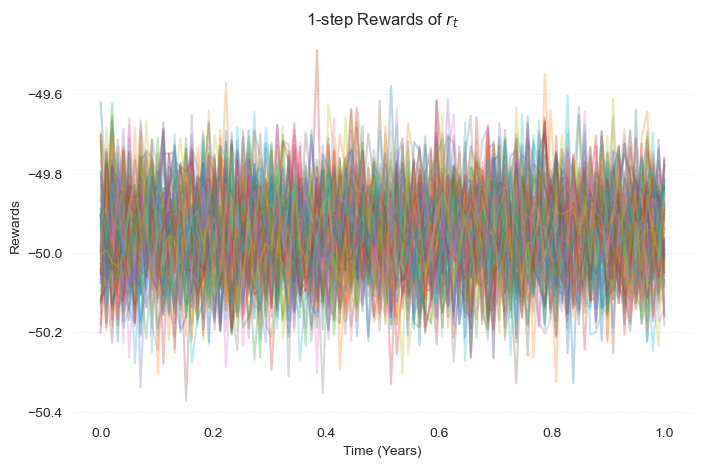

In [55]:
fig, ax = plt.subplots(figsize = (8, 5))
for i in range(100):
    ax.plot(t, R_t_paths[i], alpha = 0.3)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('1-step Rewards of $r_t$')
plt.xlabel('Time (Years)')
plt.ylabel('Rewards')
plt.show()

In [56]:
V_t_next_paths = V_t_pi_paths + gamma * np.mean(R_t_paths, axis=1)

In [61]:
V_t_next_paths

array([-82.43463653, -84.55861434, -83.97870318, -82.08800799,
       -83.5349276 , -81.85087254, -83.9225656 , -81.56982724,
       -80.83136486, -83.91745797, -85.40786428, -84.28624709,
       -83.75680652, -84.24756355, -83.9791357 , -85.12946169,
       -83.46909984, -84.59952481, -83.06514888, -83.65966262,
       -86.26430753, -83.22706436, -84.83430129, -86.32343136,
       -85.28533935, -85.37159654, -85.10269569, -83.69556838,
       -83.6424852 , -83.48376424, -83.52753133, -83.99895936,
       -84.33319047, -85.24297554, -85.49783184, -82.58959415,
       -81.69286244, -81.1061185 , -83.87692442, -86.09965074,
       -85.28534184, -85.55660416, -85.33150166, -84.26792419,
       -82.07327636, -81.71311583, -81.77457071, -84.83378182,
       -85.09124009, -85.52514239, -86.44643575, -83.90247028,
       -83.58167141, -84.1081921 , -85.33342744, -84.44640053,
       -83.24586124, -84.78256806, -82.88520234, -83.33225991,
       -83.36001223, -84.93232233, -84.87925711, -83.27

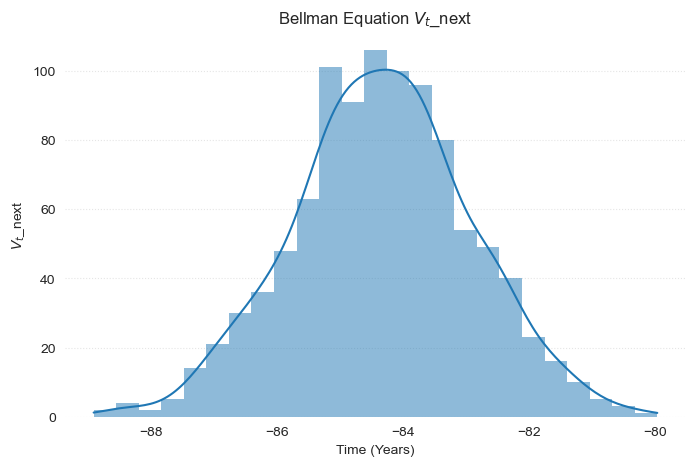

In [63]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.histplot(V_t_next_paths, ax = ax, edgecolor = 'None', kde = True)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Bellman Equation $V_t$_next')
plt.xlabel('Time (Years)')
plt.ylabel('$V_t$_next')
plt.show()